# 5. Clustering

From the previously-obtained features, we can now cluster the data. We will use the K-means algorithm, which is a simple and efficient algorithm for clustering. Depending on the task at hand, other algorithms may be more appropriate. Please
follow the [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html) for more information. 

Note that we use directly the features extracted with the inependent component analysis (ICA) as input for the clustering algorithm. This is not mandatory, and you can use the features extracted with the scattering network instead. We here opt for the ICA features because they lie in a lower-dimensional space, which makes the clustering algorithm more efficient (see the comments on the curse of dimensionality).

Made in 2022 by Léonard Seydoux and René Steinmann.

This notebook uses the __matplotlib__, __scikit-learn__ and __obspy__ library, please run the cell below if the packages are not installed.

In [1]:
# %pip install matplotlib
# %pip install scikit-learn
# %pip install obspy

In [1]:
import pickle

import matplotlib.pylab as plt
import numpy as np
import obspy
from scipy import signal
from sklearn.cluster import KMeans

plt.rcParams["date.converter"] = "concise"

## Load features

We first load the features calculated in the notebook `3_dimensionality_reduction.ipynb`. We will use the features extracted with the independent component analysis (ICA) as input for the clustering algorithm. This is not mandatory, and you can use the features extracted with the scattering network instead. We here opt for the ICA features because they lie in a lower-dimensional space, which makes the clustering algorithm more efficient (see the comments on the curse of dimensionality).

> Note: since we saved the times as Python datetime objects, we need to set the `allow_pickle` flag to `True` when loading the data, to allow for object loading.

In [24]:
# Load features and datetimes from file
with np.load("GL_independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

# Load network
network = pickle.load(open("GL_scattering_network.pickle", "rb"))

## $k$-means clustering

We now perform the clustering. We will use the $k$-means algorithm, which is a simple and efficient algorithm for clustering. Depending on the task at hand, other algorithms may be more appropriate. Please follow the [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html) for more information.

The $k$-means algorithm solves the following optimization problem:

$$ \min_{\mathbf{C}, \mathbf{Z}} \sum_{i=1}^N \sum_{k=1}^K z_{ik} \| \mathbf{x}_i - \mathbf{c}_k \|^2 $$

where $\mathbf{C} = \{\mathbf{c}_1, \ldots, \mathbf{c}_K\}$ is the set of cluster centers, $\mathbf{Z} = \{z_{1}, \ldots, z_{N}\}$ is the set of assignment vectors, and $z_{ik} = 1$ if $\mathbf{x}_i$ is assigned to cluster $k$ and $z_{ik} = 0$ otherwise. The assignment vectors are also called responsibilities.

The $k$-means algorithm requires the number of clusters as input. Several methods exist to determine this number. Here, we will define this number  manually, and allow the user to change it. Depending on the application, we chose the number of clusters differently. 

### Optimize model

We first instantiate the model, and optimize it. We define the number of clusters arbitrarily to 10. We then fit the model to the data, and predict the cluster labels for each sample.

In [25]:
N_CLUSTERS = 20#10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=4)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

### Vizualize cluster-wise detection rate

A way to vizualize the clustering results is to plot the cluster-wise detection rate as a function of the cluster number. This is done by computing the detection curve for each cluster (one-hot encoding), and then averaging the results in a sliding window with a given smoothing kernel of $N$ points.

The detection rate of a given cluster is given by the one-hot encoding of the
cluster label as a function of time. One can smooth the detection rate by
cluster by convolving it with a Gaussian kernel or a boxcar window (running average).

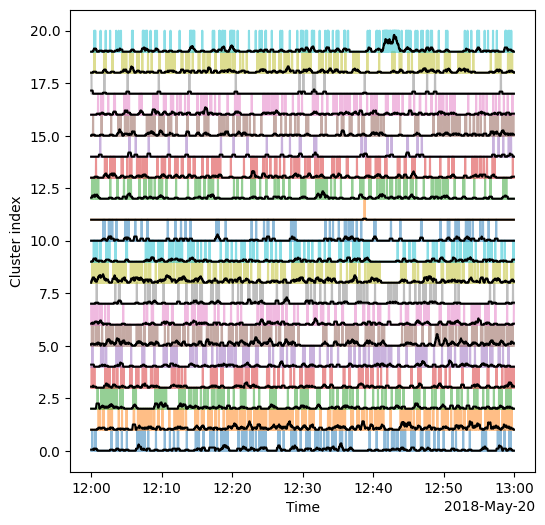

In [26]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times[:-1]), N_CLUSTERS + 1))
one_hot[np.arange(len(times[:-1])), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times[:-1], one_hot[:, i] + i, alpha=0.5)
    ax.plot(times[:-1], detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()

### Get cluster coordinates in the feature space

We here see that cluster 4 is moslty constrained by the feature 6. Looking back at the notebook 4 on the reconstruction can therefore give insights on the nature of the cluster.

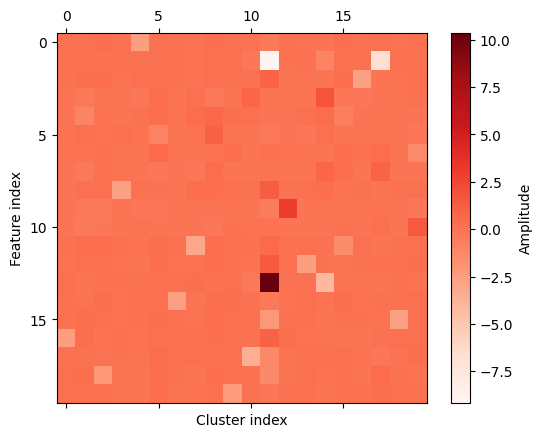

In [21]:
centroids = model.cluster_centers_

# Plot the centroids
fig = plt.figure()
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="Reds")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Show
plt.show()

## Vizualiaze within-cluster waveforms

Another way of vizualizing the clustering results is to extract the waveforms corresponding to each cluster. We can then plot the most $N$ representative waveforms for each cluster.

### Extract waveforms

We here extract the five most representative waveforms within each cluster. We narrow the focus on a single component of the waveforms, but the cell can be adapted to show all components at once.

In [27]:
len(times)
# len(predictions)
stream

3 Trace(s) in Stream:
XX.SE57..HHE | 2018-07-29T00:00:00.000000Z - 2018-08-02T23:59:59.980000Z | 50.0 Hz, 21600000 samples
XX.SE57..HHN | 2018-07-29T00:00:00.000000Z - 2018-08-02T23:59:59.980000Z | 50.0 Hz, 21600000 samples
XX.SE57..HHZ | 2018-07-29T00:00:00.000000Z - 2018-08-02T23:59:59.980000Z | 50.0 Hz, 21600000 samples

In [22]:
N_WAVEFORMS = 5

# Read the stream
stream = obspy.read("GL_scattering_stream_short.mseed").select(channel="HHZ")
waveform_duration = network.bins / network.sampling_rate

## for dealing with missing segment
times0 = times[:-1]

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times0[predictions == cluster][distance.argsort()[:5]]
    #closest = times[predictions == cluster][distance.argsort()[:5]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)

### Plot waveforms

We now plot the waveforms. We plot the five most representative waveforms for each cluster in separate axes with equal limits for comparison. Note that the very same stream that was used to infer the features and clusters are shown here. This can be changed to the spectral area where the clusters are most distinct.

We clearly see that cluster 4 has more energy that the neighboring clusters. This is a good example of how the clustering algorithm can be used to extract information from the data.

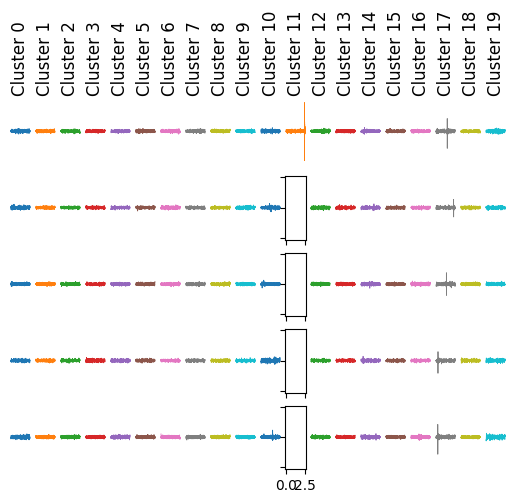

In [23]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()

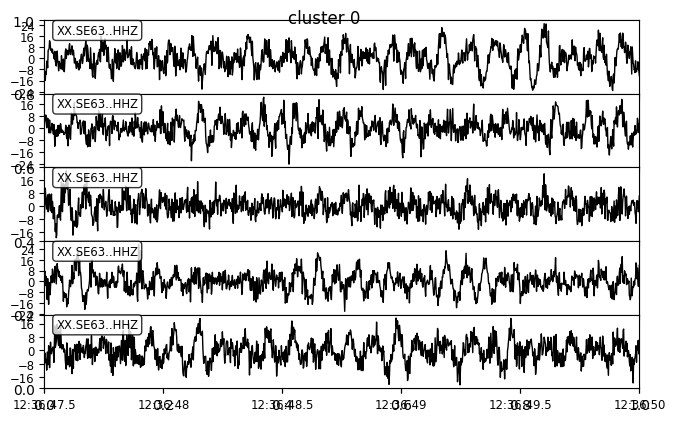

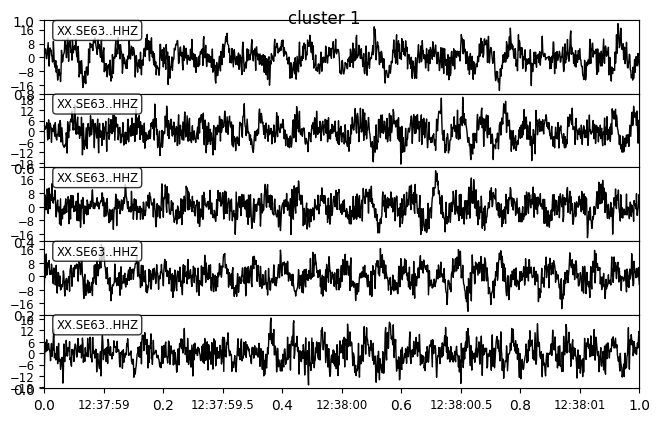

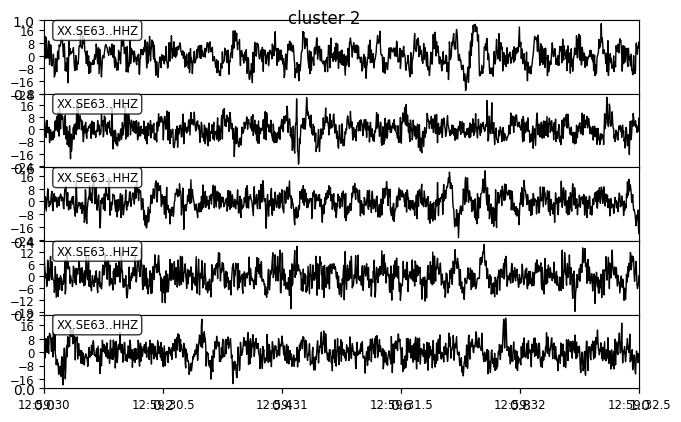

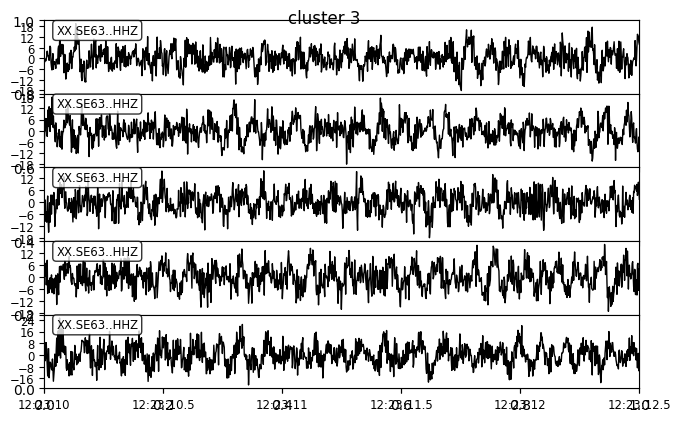

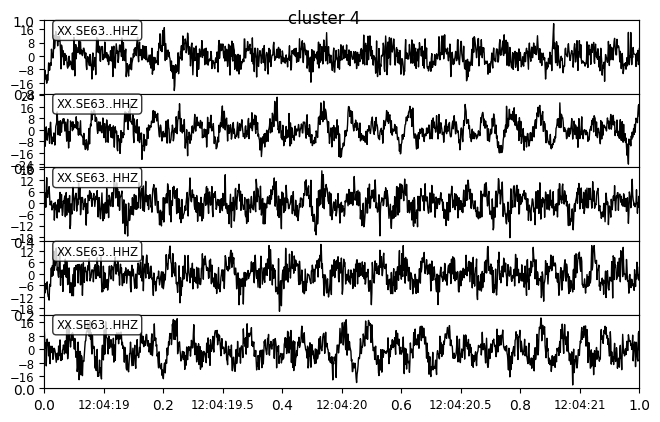

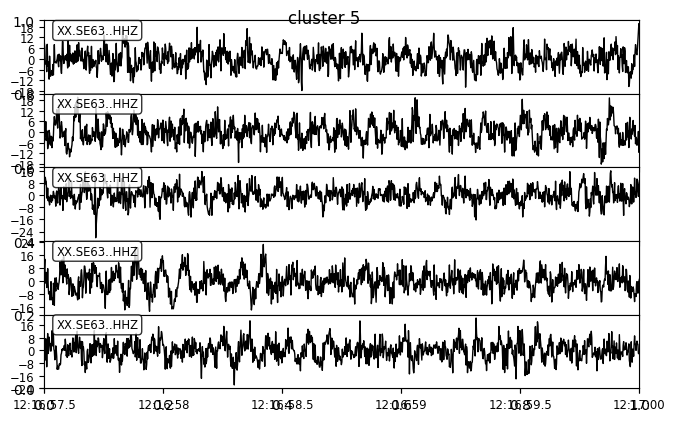

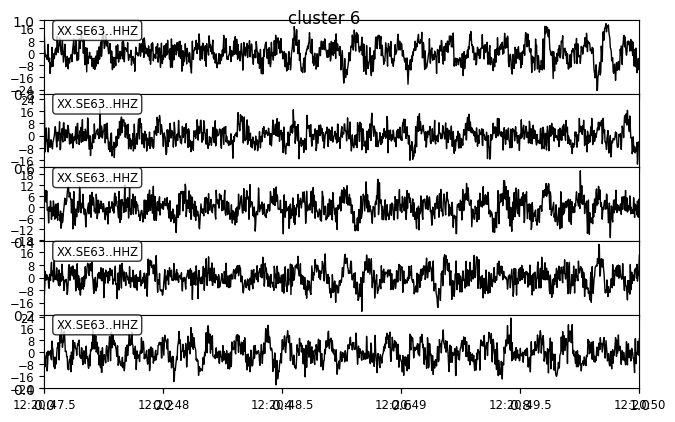

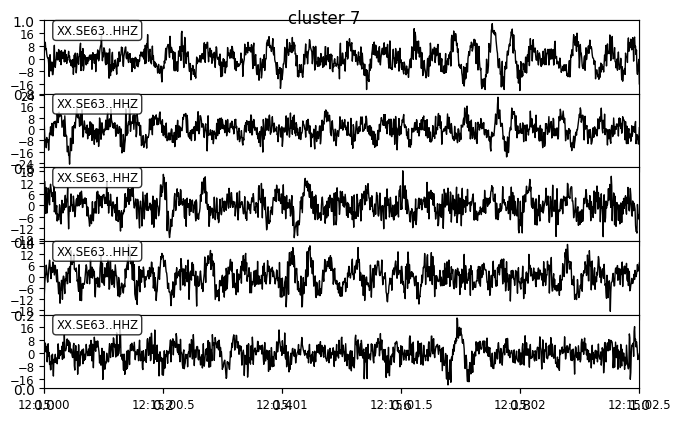

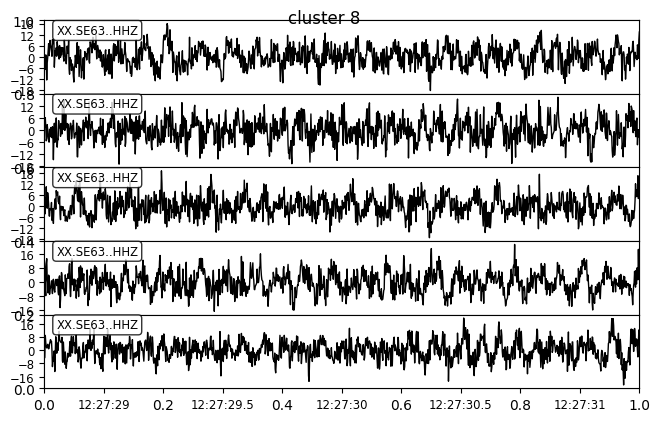

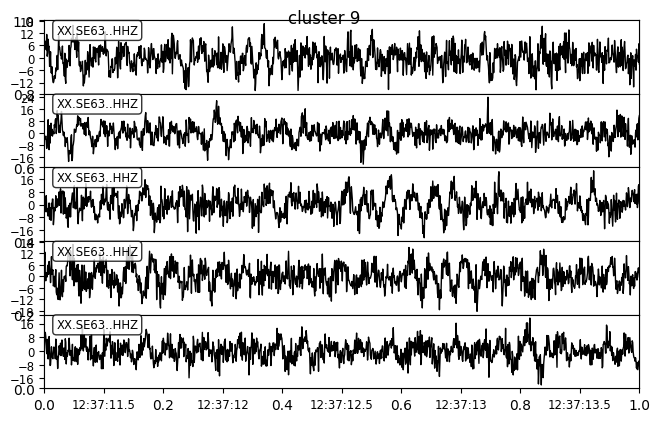

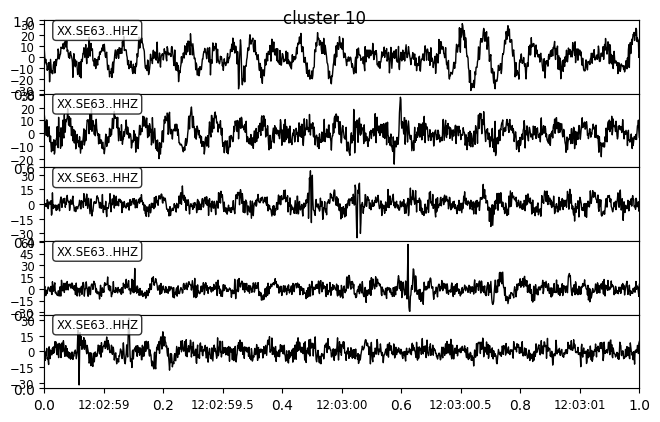

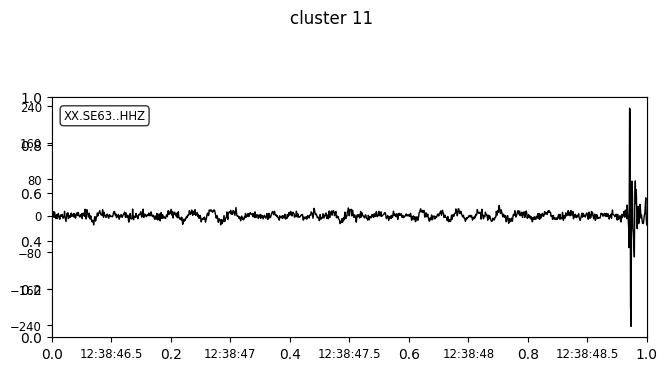

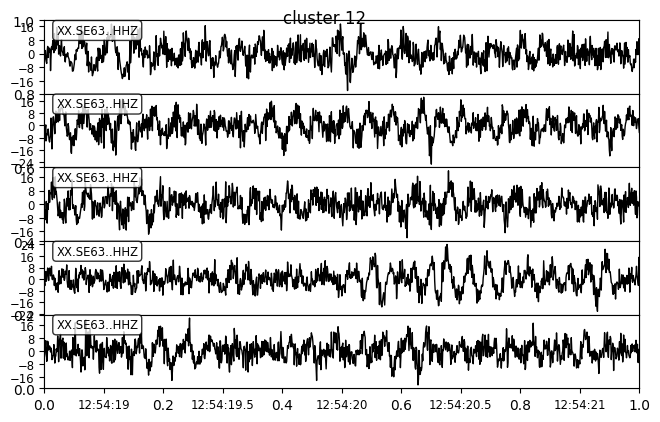

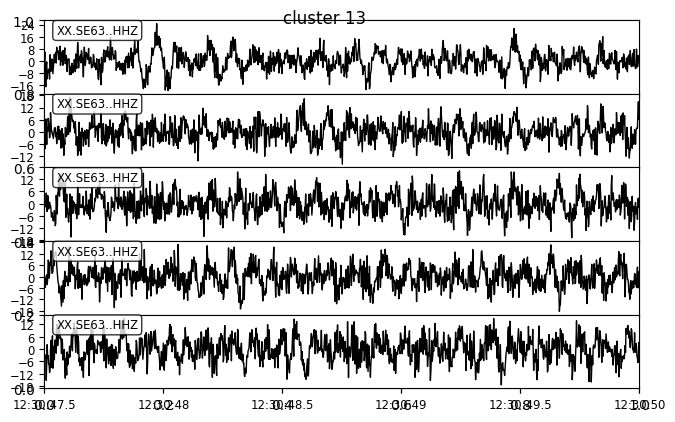

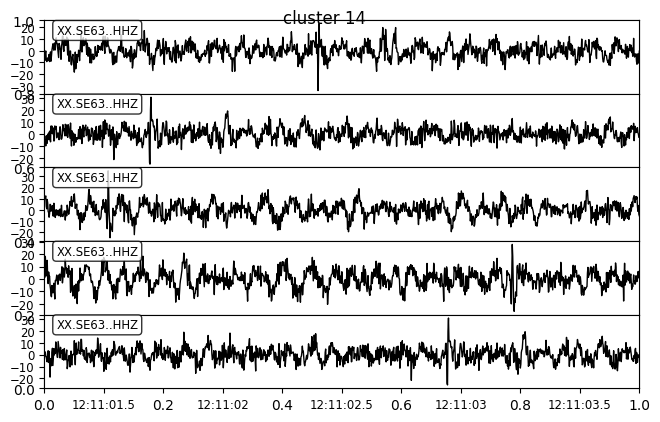

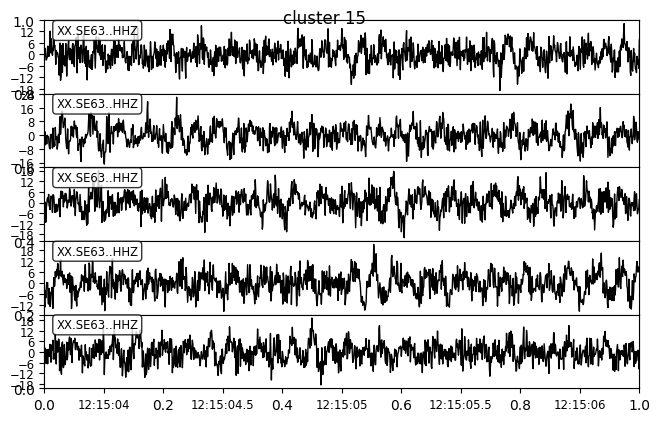

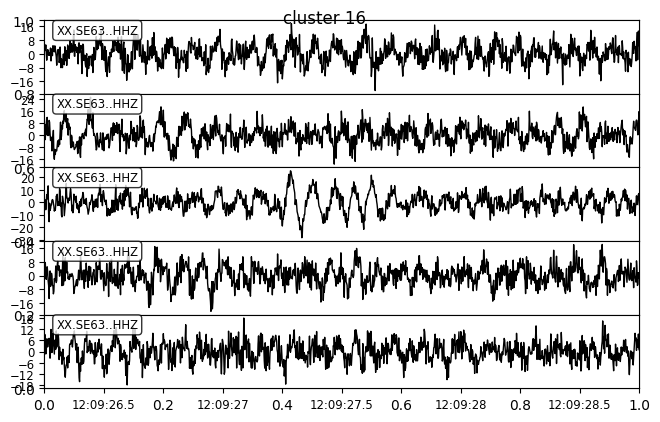

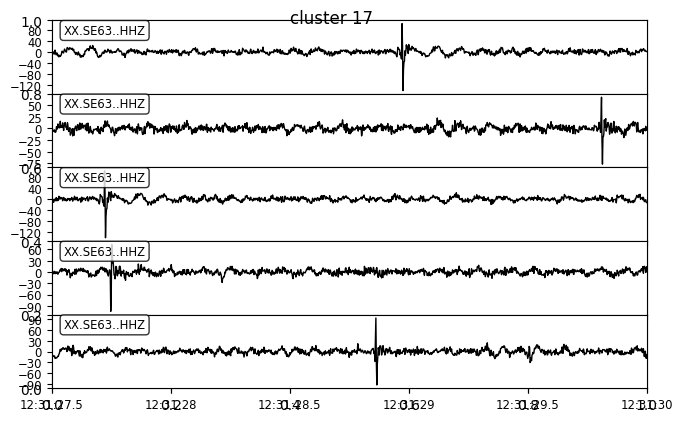

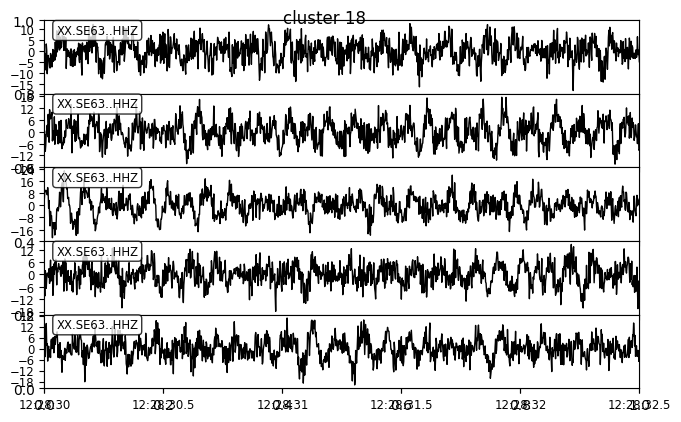

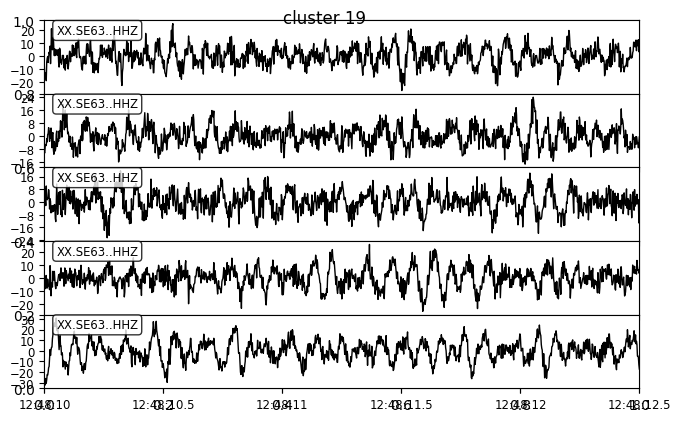

In [27]:
from obspy.core import Stream
# clustern = 4
for i, lst in enumerate(waveforms):
    st = Stream()
    for tr in lst:
        tr.stats.starttime = lst[0].stats.starttime #just for plotting
        st.append(tr)
    fig, ax = plt.subplots(1, figsize = [7,4])
    st.plot(fig=fig, equal_scale=False)
    fig.suptitle(f"cluster {i}")
    # print(st)
